In [1]:
from __future__ import annotations

import datetime
import os
import os.path as osp
import textwrap
from typing import Callable, Optional, Type

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
import seaborn as sns
import torch
import torch.nn as nn
from torch import Tensor
from tqdm.auto import tqdm, trange

import lqsvg.experiment.analysis as analysis
import lqsvg.experiment.utils as eutil
import lqsvg.torch.named as nt
import lqsvg.torch.utils as tutil
from lqsvg.envs import lqr
from lqsvg.envs.lqr.generators import LQGGenerator
from lqsvg.envs.lqr.modules import (
    InitStateDynamics,
    LinearDynamicsModule,
    LQGModule,
    QuadraticReward,
)
from lqsvg.experiment.estimators import DPG, MAAC, AnalyticSVG, MonteCarloSVG
from lqsvg.experiment.plot import default_figsize, plot_surface
from lqsvg.np_util import RNG
from lqsvg.policy.modules import QuadQValue, TVLinearPolicy

In [2]:
ray.init()

2021-06-07 17:10:06,629	INFO services.py:1172 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.15.44',
 'raylet_ip_address': '192.168.15.44',
 'redis_address': '192.168.15.44:6379',
 'object_store_address': '/tmp/ray/session_2021-06-07_17-10-06_099975_61401/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-06-07_17-10-06_099975_61401/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-06-07_17-10-06_099975_61401',
 'metrics_export_port': 46823,
 'node_id': '22c27068f67f87f806e447fb3c4600a0cbabd0c3736cbe2195ed9d96'}

In [3]:
DEBUG = False

# Matplotlib setup

Latex presets ([ref](https://jwalton.info/Embed-Publication-Matplotlib-Latex/))

In [4]:
TEXTWIDTH_PT = 347.12354

In [5]:
def set_size(width=TEXTWIDTH_PT, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [6]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10',
 'tex']

In [7]:
print(
    f"Your style sheets are located at: {osp.join(mpl.__path__[0], 'mpl-data', 'stylelib')}"
)

Your style sheets are located at: /home/angelo/.cache/pypoetry/virtualenvs/lqsvg-3RqEHojC-py3.8/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib


In [8]:
# Using seaborn's style
plt.style.use("seaborn")
# With LaTex fonts
plt.style.use("tex")

In [9]:
def figpath(name: str) -> str:
    return osp.join("images", name + ".pdf")


def savefig(fig, name):
    path = figpath(name)
    # Save and remove excess whitespace
    return fig.savefig(path, format="pdf", bbox_inches="tight")

In [10]:
if DEBUG:
    # Test
    x = np.linspace(0, 2 * np.pi, 100)
    # Initialise figure instance
    fig, ax = plt.subplots(1, 1, figsize=set_size())

    # Plot
    ax.plot(x, np.sin(x))
    ax.set_xlim(0, 2 * np.pi)
    ax.set_xlabel(r"$\theta$")
    ax.set_ylabel(r"$\sin (\theta)$")

    savefig(fig, "example")

In [11]:
if osp.exists(figpath("example")):
    os.remove(figpath("example"))

# Experimental setup

## Biased/Unbiased (DPG/MAAC) estimators

In [12]:
class KStepModules(nn.Module):
    def __init__(
        self,
        policy: TVLinearPolicy,
        transition: LinearDynamicsModule,
        reward: QuadraticReward,
        qvalue: QuaQValue,
    ):
        super().__init__()
        self.policy = policy
        self.transition = transition
        self.reward = reward
        self.qvalue = qvalue


class KStepEstimator(nn.Module):
    def __init__(
        self, modules: KStepModules, obs: Tensor, kind: Union[Type[DPG], Type[MAAC]]
    ):
        super().__init__()
        self.nn = modules
        self.state_dataset = obs
        self.kind = kind
        self.estimator = self.kind(
            modules.policy, modules.transition, modules.reward, modules.qvalue
        )
        self.n_steps: int = 0

    def sample_starting_obs(self, samples: int) -> Tensor:
        if samples == self.state_dataset.size("B"):
            return self.state_dataset
        idxs = torch.randint(low=0, high=self.state_dataset.size("B"), size=(samples,))
        return nt.index_select(self.state_dataset, dim="B", index=idxs)

    def surrogate(self, samples: int = 1) -> Tensor:
        obs = self.sample_starting_obs(samples)
        return self.estimator.surrogate(obs, n_steps=self.n_steps)

    def forward(self, samples: int = 1) -> tuple[Tensor, lqr.Linear]:
        obs = self.sample_starting_obs(samples)
        return self.estimator(obs, n_steps=self.n_steps)

    def delta_to_surrogate(
        self, samples: int, n_step: int, update_q: bool = False
    ) -> Callable[[np.ndarray], np.ndarray]:
        K_0, k_0 = self.nn.policy.standard_form()

        @torch.no_grad()
        def f_delta(delta: np.ndarray) -> np.ndarray:
            vector = nt.vector(tutil.as_float_tensor(delta))
            delta_K, delta_k = tutil.vector_to_tensors(vector, (K_0, k_0))
            policy = TVLinearPolicy.from_existing((K_0 + delta_K, k_0 + delta_k))
            if update_q:
                qvalue = QuadQValue.from_policy(
                    policy.standard_form(),
                    self.nn.transition.standard_form(),
                    self.nn.reward.standard_form(),
                )
            else:
                qvalue = self.nn.qvalue
            modules = KStepModules(policy, self.nn.transition, self.nn.reward, qvalue)
            estimator = KStepEstimator(modules, self.state_dataset, self.kind)
            estimator.n_steps = n_step
            surrogate = estimator.surrogate(samples)
            return surrogate.numpy()

        return f_delta

## Environment and policy generation

LQG parameters: 
1. $|S| = 2, |A| = 2, |H| = 20$
2. Stationary dynamics and cost
3. Passive dynamics eigvals $|\lambda_i| \sim \mathcal{U}(0.5, 1.5)$
4. Controllable
5. Transition covariance $\Sigma = I$
6. Cost $s^\intercal C_{ss} s + a^\intercal C_{aa} a$

In [13]:
def make_generator(seed: int) -> LQGGenerator:
    return LQGGenerator(
        n_state=2,
        n_ctrl=2,
        horizon=20,
        stationary=True,
        passive_eigval_range=(0.5, 1.5),
        controllable=True,
        rng=seed,
    )

In [14]:
def grad_estimates(
    estimator,
    sample_sizes: list[int],
    estimates_per_sample_size: int = 10,
    pbar: bool = False,
) -> list[list[lqr.Linear]]:
    """Helper to sample several SVG estimates for different sample sizes."""
    progress = tqdm(
        sample_sizes, desc="Computing SVG by sample size", leave=False, disable=not pbar
    )
    svgs_by_sample_size = []
    for size in progress:
        svgs = [estimator(samples=size)[1] for _ in range(estimates_per_sample_size)]
        svgs_by_sample_size += [svgs]
    return svgs_by_sample_size

In [15]:
class Trial:
    def __init__(self, seed: int, total_states: int = 1000):
        self.rng = np.random.default_rng(seed)
        self.generator = make_generator(self.rng)
        self.lqg, self.policy, self.qvalue = self.make_modules(self.generator)

        with tutil.default_generator_seed(seed):
            self.states = self.starting_states(self.policy, self.lqg, total_states)

        modules = KStepModules(
            self.policy, self.lqg.trans, self.lqg.reward, self.qvalue
        )
        self.estimator = {
            "dpg": KStepEstimator(modules, self.states, kind=DPG),
            "maac": KStepEstimator(modules, self.states, kind=MAAC),
        }

    def make_modules(
        self, generator: LQGGenerator
    ) -> tuple[LQGModule, TVLinearPolicy, QuadQValue]:
        with nt.suppress_named_tensor_warning():
            dynamics, cost, init = generator()
        model = LQGModule.from_existing(dynamics, cost, init)
        policy = TVLinearPolicy(model.n_state, model.n_ctrl, model.horizon)
        policy.stabilize_(dynamics, rng=self.rng)
        qvalue = QuadQValue.from_policy(policy.standard_form(), dynamics, cost)
        return model, policy, qvalue

    @staticmethod
    def starting_states(policy: TVLinearPolicy, model: LQGModule, num: int) -> Tensor:
        rollout_module = MonteCarloSVG(policy, model)
        n_trajs = num // model.horizon
        with torch.no_grad():
            obs, _, _, _, _ = rollout_module.rsample_trajectory(torch.Size([n_trajs]))
        obs = obs.flatten(["H", "B1"], "B")
        return obs

# Experiments

## Gradient estimation for fixed policies

In [16]:
@ray.remote
class GradientQualityTrial(Trial):
    """Helper to collect gradient quality metrics for a specific environment-policy pair.

    Environment-policy pair determined by seed.
    """

    def __init__(self, seed: int, total_states: int):
        super().__init__(seed, total_states)
        _, self.true_svg = AnalyticSVG(self.policy, self.lqg)()

    def gradient_quality_vs_samples(
        self, sample_sizes: np.ndarray, n_step: int, estimates: int
    ) -> pd.DataFrame:
        rows = sum(
            (self.gradient_estimation_data(s, n_step, estimates) for s in sample_sizes),
            start=[],
        )
        columns = [
            "#Samples",
            "Avg. cos sim with true grad",
            "Avg. pairwise cos sim",
            "Norm",
            "Estimator",
        ]
        data = pd.DataFrame(rows, columns=columns)
        data["K"] = n_step
        data["trial"] = self.generator.rng
        return data

    def gradient_estimation_data(
        self, samples: int, n_step: int, estimates: int
    ) -> list:
        rows = []
        for name, estimator in self.estimator.items():
            svgs = self.grad_estimates(estimator, samples, n_step, estimates)
            cossim = analysis.gradient_accuracy(svgs, self.true_svg)
            empvar = analysis.empirical_variance(svgs)
            norm = np.mean([eutil.linear_feedback_norm(s).numpy() for s in svgs])
            rows += [[samples, cossim, empvar, norm, name]]

        return rows

    @staticmethod
    def grad_estimates(
        estimator, samples: int, n_step: int, estimates: int = 10
    ) -> list[lqr.Linear]:
        old = estimator.n_steps
        estimator.n_steps = n_step
        estimates = [estimator(samples)[1] for _ in range(estimates)]
        estimator.n_steps = old
        return estimates

In [17]:
class GradientQualityComparison:
    """Helper to collect gradient quality metrics over several environment-policy pairs.

    Uses Ray to distribute computation via trial Actors.
    """

    def __init__(self, seeds: list[int], total_states: int = 1000):
        self.seeds = seeds
        self.total_states = total_states
        self.actors = None
        self.data = None

    def collect(self, sample_sizes: np.ndarray, n_steps: np.ndarray):
        if self.actors is None:
            self.actors = [
                GradientQualityTrial.remote(seed=s, total_states=self.total_states)
                for s in self.seeds
            ]

        remaining = [
            a.gradient_quality_vs_samples.remote(sample_sizes, n_step=k, estimates=10)
            for k in n_steps
            for a in self.actors
        ]
        ready = []
        with tqdm(desc="Collecting", total=len(remaining)) as pbar:
            while remaining:
                done, remaining = ray.wait(remaining)
                ready += done
                pbar.update(len(done))
        self.data = pd.concat(ray.get(ready), ignore_index=True)

    def save(self, name: str = ""):
        assert self.data is not None
        now = datetime.datetime.now().isoformat(timespec="minutes")
        fname = f"{type(self).__name__}-{now}.csv"
        prfx = name + "-" if name else ""
        path = osp.join("local", prfx + fname)
        self.data.to_csv(path, index=False)

    def load(self, path: str):
        assert self.data is None
        self.data = pd.read_csv(path, index_col=False)

### Bias/variance vs. sample size vs. K steps

In [18]:
# comp = GradientQualityComparison(seeds=np.arange(10), total_states=1000)
# comp.collect(
#     sample_sizes=np.linspace(1, comp.total_states, 200, dtype=int), n_steps=[2]
# )
# comp.save("BiasVarianceNorm-K=2")

In [19]:
def fgrid_size(rows: int, cols: int, **setsize_kws) -> dict:
    """Kwargs to set FacetGrid size based on number of rows and cols."""
    w, h = set_size(subplots=(rows, cols), **setsize_kws)
    return dict(height=h / rows, aspect=(w / cols) / (h / rows))


def plot_gradient_acc(data):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Avg. cos sim with true grad",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci=95,
        facet_kws=dict(legend_out=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Accuracy")
    fgrid.tight_layout()
    return fgrid


def plot_gradient_var(data):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Avg. pairwise cos sim",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci=95,
        facet_kws=dict(legend_out=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Variance")
    fgrid.tight_layout()
    return fgrid

In [20]:
BIAS_VAR_NORM_DATA = pd.concat(
    (
        pd.read_csv(
            "local/BiasVarianceNorm-K=0,4,8-GradientQualityComparison-2021-05-28T12:04.csv",
            index_col=False,
        ),
        pd.read_csv(
            "local/BiasVarianceNorm-K=2-GradientQualityComparison-2021-05-31T11:04.csv",
            index_col=False,
        ),
    ),
    ignore_index=True,
)

rows: 2, cols: 2


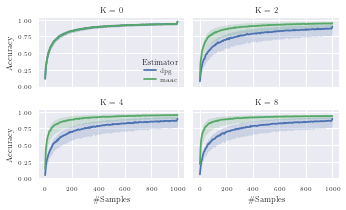

In [21]:
savefig(plot_gradient_acc(BIAS_VAR_NORM_DATA), "GradientAcc")

rows: 2, cols: 2


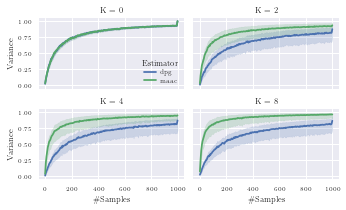

In [22]:
savefig(plot_gradient_var(BIAS_VAR_NORM_DATA), "GradientVar")

### Gradient signal strength

In [23]:
def plot_gradient_norm(data, agg: bool = True):
    cols = 2
    rows = (len(data["K"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")

    fgrid = sns.relplot(
        kind="line",
        data=data,
        x="#Samples",
        y="Norm",
        hue="Estimator",
        col="K",
        col_wrap=cols,
        ci="sd",
        facet_kws=dict(legend_out=False, sharey=False),
        **fgrid_size(rows, cols, fraction=1),
    )
    for nstep, ax in fgrid.axes_dict.items():
        ax.set_ylim(np.percentile(data[data["K"] == nstep]["Norm"], [2.5, 97.5]))
#     fgrid.set(ylim=np.percentile(data["Norm"], [2.5, 97.5]))
    fgrid.set_xlabels("\#Samples")
    fgrid.set_ylabels("Gradient norm")
    fgrid.tight_layout()
    return fgrid

rows: 2, cols: 2


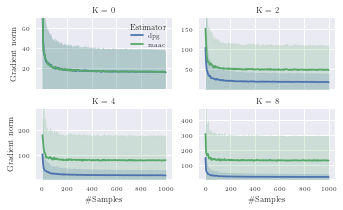

In [24]:
savefig(plot_gradient_norm(BIAS_VAR_NORM_DATA, agg=False), "GradientNorm")

### Estimator bias at convergence

In [25]:
# comp = GradientQualityComparison(seeds=np.arange(10), total_states=50000)
# comp.collect([comp.total_states], np.arange(1, 21))
# comp.save("Convergence")

In [26]:
CONVERGENCE_DATA = pd.read_csv(
    "local/Convergence-GradientQualityComparison-2021-05-25T15.20.csv", index_col=False
)

In [27]:
CONVERGENCE_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   #Samples                     400 non-null    int64  
 1   Avg. cos sim with true grad  400 non-null    float64
 2   Avg. pairwise cos sim        400 non-null    float64
 3   Norm                         400 non-null    float64
 4   Estimator                    400 non-null    object 
 5   K                            400 non-null    int64  
 6   trial                        400 non-null    object 
dtypes: float64(3), int64(2), object(2)
memory usage: 22.0+ KB


In [28]:
def plot_acc_vs_nstep(data):
    data = data[data["#Samples"] == data["#Samples"].max()]
    fig, ax = plt.subplots(1, 1, figsize=set_size(fraction=0.7))
    sns.scatterplot(
        ax=ax,
        data=data,
        x="K",
        y="Avg. cos sim with true grad",
        hue="Estimator",
        style="Estimator",
        s=10,  # Marker size https://stackoverflow.com/a/52785672/7842251
        alpha=.75,
    )
    ax.set_xlabel("$K$")
    ax.set_ylabel("Cosine similarity")
    ax.set_xticks(data["K"].unique()[::2])
    ax.legend(markerscale=.75)
    return savefig(fig, "convergence")

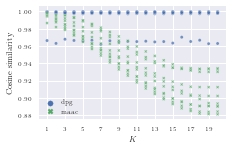

In [29]:
plot_acc_vs_nstep(CONVERGENCE_DATA)

## Impact of gradient quality on policy optimization

In [30]:
from typing import Iterable, TypeVar

from raylab.utils.exp_data import load_exps_data

T = TypeVar("T")

In [31]:
def dict_exclude(mapping: dict[str, T], keys: Iterable[str]) -> dict[str, T]:
    return {k: mapping[k] for k in set(mapping.keys()).difference(set(keys))}


def push_config_to_dataframe(exp_data):
    progress = exp_data.progress
    params = dict_exclude(exp_data.params, ["wandb_tags", "wandb_dir"])
    return pd.concat((progress, pd.DataFrame(params, index=progress.index)), axis=1)


def read_optimization_data(path: str) -> pd.DataFrame:
    exps_data = load_exps_data(path)
    dfs = [push_config_to_dataframe(e) for e in exps_data]
    return pd.concat(dfs, ignore_index=True)

In [32]:
OPTIMIZATION_DATA = read_optimization_data("results/Experiment_2021-06-07_09-25-12/")
OPTIMIZATION_DATA.head()

,true_value,optimal_value,episode_reward_mean,episode_reward_max,episode_reward_min,done,timesteps_total,episodes_total,training_iteration,experiment_id,...,trial_id,K,normalize_svg,env_seed,B,estimator,exp_name,learning_rate,policy_seed,id
0,-483.535492,66.275909,-579.011043,0.0,-1029.002441,False,NaN,NaN,1,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,8,True,4,200,dpg,Experiment_2021-06-07_09-25-12,0.01,2,67d8a_00084
1,-480.538269,66.275909,-511.882672,0.0,-1029.002441,False,NaN,NaN,2,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,8,True,4,200,dpg,Experiment_2021-06-07_09-25-12,0.01,2,67d8a_00084
2,-477.757080,66.275909,-451.761725,0.0,-1029.002441,False,NaN,NaN,3,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,8,True,4,200,dpg,Experiment_2021-06-07_09-25-12,0.01,2,67d8a_00084
3,-474.939087,66.275909,-447.503235,0.0,-1029.002441,False,NaN,NaN,4,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,8,True,4,200,dpg,Experiment_2021-06-07_09-25-12,0.01,2,67d8a_00084
4,-471.864990,66.275909,-480.956620,0.0,-2136.937988,False,NaN,NaN,5,f48f9f7e2f504a9082617765f26f5bae,...,67d8a_00084,8,True,4,200,dpg,Experiment_2021-06-07_09-25-12,0.01,2,67d8a_00084


In [33]:
OPTIMIZATION_DATA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387000 entries, 0 to 386999
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   true_value                387000 non-null  float64
 1   optimal_value             387000 non-null  float64
 2   episode_reward_mean       387000 non-null  float64
 3   episode_reward_max        387000 non-null  float64
 4   episode_reward_min        387000 non-null  float64
 5   done                      387000 non-null  bool   
 6   timesteps_total           0 non-null       float64
 7   episodes_total            0 non-null       float64
 8   training_iteration        387000 non-null  int64  
 9   experiment_id             387000 non-null  object 
 10  date                      387000 non-null  object 
 11  timestamp                 387000 non-null  int64  
 12  time_this_iter_s          387000 non-null  float64
 13  time_total_s              387000 non-null  f

In [34]:
HUE_ORDER = "dpg maac".split()

In [62]:
def learning_curves(data, ci="sd"):
    data = data[~np.isin(data["env_seed"], (2, 7))]
    data = data.copy()
    data["Iteration"] = data["training_iteration"]
    data["Cost"] = -data["true_value"]
    data["seed"] = data["env_seed"]

    cols = 2
    rows = (len(data["seed"].unique()) + 1) // cols
    print(f"rows: {rows}, cols: {cols}")
    w, h = set_size(fraction=1, subplots=(rows, cols))
    print(f"width: {w}, height: {h}")

    fgrid = sns.relplot(
        data=data,
        kind="line",
        x="Iteration",
        y="Cost",
        hue="estimator",
        hue_order=HUE_ORDER,
        ci="sd",
        col="seed",
        col_wrap=cols,
        height=h / rows,
        aspect=(w / cols) / (h / rows),
        facet_kws={"sharey": False, "sharex": True, "legend_out": False},
    )
    for ax in fgrid.axes:
        ax.set_title(None)
    for seed, ax in fgrid.axes_dict.items():
        ax.set_ylim(top=np.percentile(data[data["seed"] == seed]["Cost"], 97.5))
    fgrid.tight_layout()
    return fgrid

### Unnormalized gradients

rows: 4, cols: 2
width: 4.803148471011484, height: 5.937018016194373


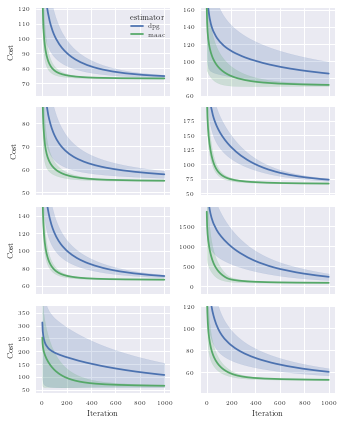

In [63]:
savefig(
    learning_curves(OPTIMIZATION_DATA[OPTIMIZATION_DATA["normalize_svg"] == False]),
    "unnormalized_svg_optimization",
)

### Normalized gradients

rows: 4, cols: 2
width: 4.803148471011484, height: 5.937018016194373


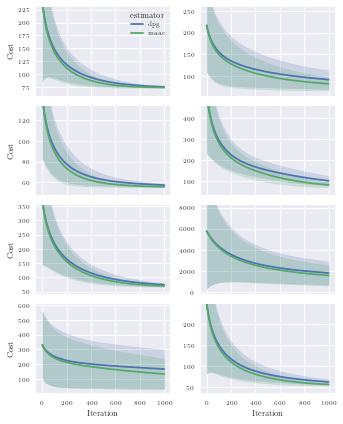

In [64]:
savefig(
    learning_curves(OPTIMIZATION_DATA[OPTIMIZATION_DATA["normalize_svg"] == True]),
    "normalized_svg_optimization",
)

## Optimization surface

In [ ]:
assert False  # Avoid running experiments below

In [ ]:
class OptimizationSurfaceComparison(Trial):
    def plot_real_vs_surrogate(
        self, estimator: str, samples: int, n_step: int, seed: Optional[int] = None
    ):
        sns.reset_orig()
        estim = self.estimator[estimator]
        estim.n_steps = n_step

        seed = seed or self.rng.integers(np.iinfo(int).max)
        with tutil.default_generator_seed(seed):
            _, svg = estim(samples)
            direction = tutil.tensors_to_vector(svg).numpy()

            real_XYZ = analysis.optimization_surface(
                self.delta_to_return(),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )
            surrogate_XYZ = analysis.optimization_surface(
                estim.delta_to_surrogate(samples, n_step, update_q=False),
                direction=direction,
                max_scaling=3.0,
                steps=20,
                rng=seed,
            )

        fig = plt.figure(figsize=default_figsize(2, 4))
        ax1 = fig.add_subplot(1, 2, 1, projection="3d")
        ax2 = fig.add_subplot(1, 2, 2, projection="3d")
        plot_surface(*real_XYZ, ax=ax1, invert_xaxis=True)
        plot_surface(*surrogate_XYZ, ax=ax2, invert_xaxis=True)
        ax1.set_xlabel("Random direction")
        ax2.set_xlabel("Random direction")
        ax1.set_ylabel(f"SVG ({estimator}) direction")
        ax2.set_ylabel(f"SVG ({estimator}) direction")
        ax1.set_zlabel("Policy return")
        ax2.set_zlabel("Surrogate value")
        fig.suptitle(f"NStep: {n_step}")
        plt.show()

    def delta_to_return(self) -> Callable[[np.ndarray], np.ndarray]:
        policy = self.policy.standard_form()
        dynamics, cost, init = self.lqg.standard_form()
        return analysis.delta_to_return(policy, dynamics, cost, init)

In [ ]:
comparator = OptimizationSurfaceComparison(4)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=10, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=10, seed=4)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=20, seed=4)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=20, seed=4)

In [ ]:
# comparator = OptimizationSurfaceComparison(4)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=0, update_q=True)
# comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=3, update_q=True)
# comparator.plot_real_vs_surrogate("maac", samples=200, n_step=3, update_q=True)

In [ ]:
comparator = OptimizationSurfaceComparison(42)
comparator.plot_real_vs_surrogate("dpg", samples=200, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=200, n_step=4, seed=42)

In [ ]:
comparator.plot_real_vs_surrogate("dpg", samples=500, n_step=4, seed=42)
comparator.plot_real_vs_surrogate("maac", samples=500, n_step=4, seed=42)